In [1]:
from library.functions_to_abstract_data import extract_qm9_data
from sklearn.model_selection import train_test_split
from torch_geometric.datasets import QM9
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

/usr/local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the QM9 dataset or install if not already installed
dataset = QM9(root='../data/QM9')

df = extract_qm9_data(dataset)
# Count occurrences of each unique gap value
gap_counts = df['gap'].value_counts()

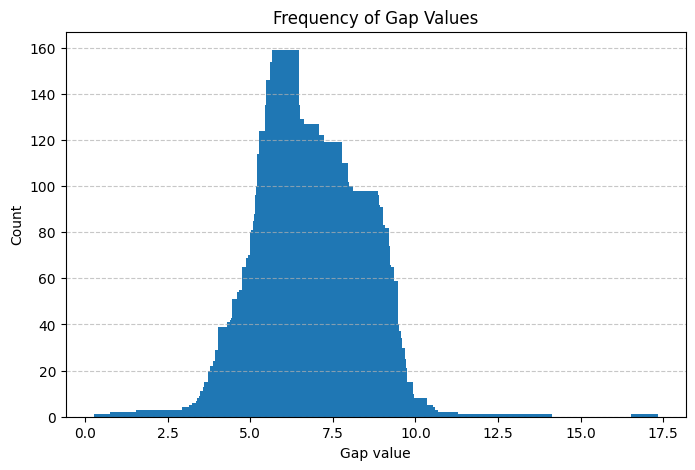

In [3]:
# Plot
plt.figure(figsize=(8, 5))
plt.bar(gap_counts.index, gap_counts.values)

# Labels and title
plt.xlabel('Gap value')
plt.ylabel('Count')
plt.title('Frequency of Gap Values')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [12]:
# Create Stratification Bins

# Option A: Quantile bins (balances number of samples per bin
num_bins = 10  # 10 bins for deciles (tune as needed)
df['gap_bin'] = pd.qcut(df['gap'], q=num_bins, labels=False)

# DOESNT WORK
# # Option B: Fixed-width bins (preserves physical scale)
# bin_width = 2.0  # eV
# bins = np.arange(df['gap'].min(), df['gap'].max() + bin_width, bin_width)
# df['gap_bin'] = np.digitize(df['gap'], bins)

df['gap_bin']

0         9
1         9
2         9
3         9
4         9
         ..
130826    7
130827    8
130828    7
130829    8
130830    8
Name: gap_bin, Length: 130831, dtype: int64

In [14]:
# Stratified Train/Test Split
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df['gap_bin']
)

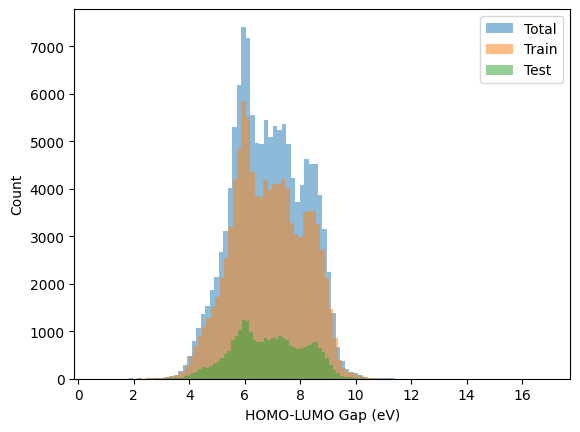

In [ ]:
# Verify the Stratification
plt.hist(df['gap'], bins=100, alpha=0.5, label='Total')
plt.hist(train_df['gap'], bins=100, alpha=0.5, label='Train')
plt.hist(test_df['gap'], bins=100, alpha=0.5, label='Test')
plt.xlabel('HOMO-LUMO Gap (eV)')
plt.ylabel('Count')
plt.legend()
plt.show()

In [27]:
df["gap"].max()

bools = df["gap"] == df["gap"].max()

for i, val in enumerate(bools):
    if val is True:
        print(i)

df.iloc[180]

180


index                                                      180
smiles                                               FC(F)(F)F
num_atoms                                                    5
mu                                                      0.0003
alpha                                                    15.93
HOMO                                                  -11.6628
LUMO                                                  5.265403
gap                                                  16.928204
r2                                                  279.320801
zpve                                                  0.466594
U0                                               -11904.569336
U298                                             -11904.462891
H298                                               -11904.4375
G298                                              -11905.30957
Cv                                                      12.639
U0_atom                                             -20